In [23]:
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [24]:
k,gamma,D = 1.0,1.0,1.0
delta_t=0.01
ampl = np.sqrt(2*D*delta_t)
N=1000

In [25]:
# random force
w=np.random.normal(0,1,N)

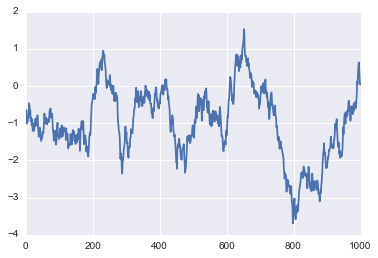

In [26]:
# differential equation x_i = x_(i-1) - k/gamma*x_(i-1) + sqrt(2*D*delta_t)*w_i
from itertools import accumulate
def next_point(x,y):
    return x - k/gamma*x*delta_t + ampl*y

x = np.fromiter(accumulate(w, next_point),np.float)
plt.plot(x)

In [27]:
print("std: ",x.std(),"mean: ",x.mean())

std:  0.938180215078 mean:  -0.993421964009


In [28]:
# see http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.fftconvolve.html
from scipy import signal
autocorr = signal.fftconvolve(x, x[::-1], mode='full')

1999


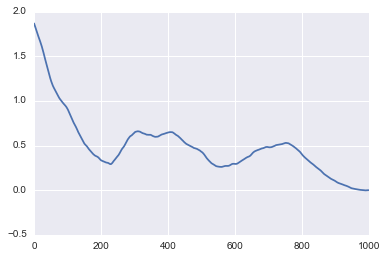

In [29]:
n=len(autocorr)
print(n)
autocorr=autocorr[int((n-1)/2):]*2.0/(n+1)
plt.plot(autocorr[:1000])

In [30]:
import lmfit as lm

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 29.618
    reduced chi-square = 0.059
    Akaike info crit   = -1407.112
    Bayesian info crit = -1398.682
[[Variables]]
    amplitude:   1.35220582 +/- 0.030498 (2.26%) (init= 0.9395749)
    decay:       313.506241 +/- 12.48831 (3.98%) (init= 614.6016)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.759 



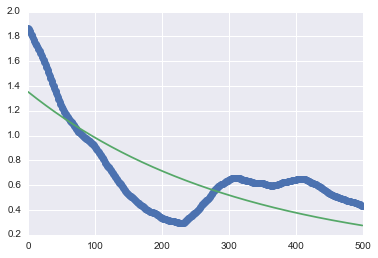

In [31]:
from lmfit.models import ExponentialModel

mod = ExponentialModel()
y = autocorr[:500]
t = np.arange(500)

pars = mod.guess(y, x=t)
out  = mod.fit(y, pars, x=t)
print(out.fit_report(min_correl=0.25))

plt.plot(t,y,"o")
plt.plot(t,out.best_fit)

In [32]:
# now lets model this data using pymc
import pymc3 as pm

In [ ]:
# define the model/function for diffusion in a harmonic potential
DHP_model = pm.Model()
with DHP_model:
    t = pm.Uniform('t', 0.1, 20)
    A = pm.Uniform('A', 0.1, 10)
    
    S=1-pm.exp(-4*delta_t/t)
    
    s=pm.exp(-2*delta_t/t)
        
    path = np.empty(N, dtype=object)
    
    path[0]=pm.Normal('path_0',mu=0, tau=1/A, observed=x[0])
    for i in range(1,N):
        path[i] = pm.Normal('path_%i' % i,
                            mu=path[i-1]*s,
                            tau=1/A/S,
                            observed=x[i])


INFO (theano.gof.compilelock): Refreshing lock /Users/hstrey/.theano/compiledir_Darwin-15.4.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock


Applied interval-transform to t and added transformed t_interval to model.
Applied interval-transform to A and added transformed A_interval to model.


INFO (theano.gof.compilelock): Refreshing lock /Users/hstrey/.theano/compiledir_Darwin-15.4.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/hstrey/.theano/compiledir_Darwin-15.4.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/hstrey/.theano/compiledir_Darwin-15.4.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock


In [ ]:
with DHP_model:
    start = pm.find_MAP()
    print(start)

00001	#include <Python.h>
00002	#include <iostream>
00003	#include "theano_mod_helper.h"
00004	#include <math.h>
00005	#include <numpy/arrayobject.h>
00006	#include <numpy/arrayscalars.h>
00007	#include <vector>
00008	#include <algorithm>
00009	//////////////////////
00010	////  Support Code
00011	//////////////////////
00012	
00013	
00014	    namespace {
00015	    struct __struct_compiled_op_m18c2d1769d722c096d7fa5567d963df6 {
00016	        PyObject* __ERROR;
00017	
00018	        PyObject* storage_V3;
00019	PyObject* storage_V5;
00020	PyObject* storage_V7;
00021	PyObject* storage_V9;
00022	PyObject* storage_V11;
00023	PyObject* storage_V13;
00024	PyObject* storage_V15;
00025	PyObject* storage_V17;
00026	PyObject* storage_V19;
00027	PyObject* storage_V21;
00028	PyObject* storage_V23;
00029	PyObject* storage_V25;
00030	PyObject* storage_V27;
00031	PyObject* storage_V29;
00032	PyObject* storage_V31;
00033	PyObject* storage_V33;
00034	PyObject* storage_V35;
00035	PyObject* storage_V37;
00

In [ ]:
with DHP_model:
    trace = pm.sample(10000,start=start)

In [ ]:
pm.traceplot(trace)

In [ ]:
pm.summary(trace)